# QA data and interepolation

## 3.4.2 QA data


### 3.4.2.1 Why QA data?

The quality of data varies according to sampling and other factors. For satellite-derived data using optical wavelengths, the two main controls are orbital constraints and cloud cover. We generally define a 'quaity' data layer to express this.

To use a satellite-derived dataset, we need to look at 'quality' data for dataset (and/or uncertainty).

For example, if interpolating data, we would want to base the weight we put on any sample on the 'quality' of that sample. This will be expressed by either some QC (Quality Control) assessment ('good', 'ok', 'bad') or some measure of uncertainty (or both).

Here, we will use the QA information in the LAI product to generate a sample weighting scheme. We shall later use this weighting for data smoothing and interpolation.

First, let's access the LAI and QA datasets.

We can do this by specifying either `Lai_500m` or `FparLai_QC` in the dataset label.

### 3.4.2.2 Set condition variables


Let's set up the variables we will use, including a pattern to match the `tile` information we need.

Here, we have:

    tile = 'h1[7-8]v0[3-4]'
    
which we can interpret as:

    h17v03, h17v04, h18v03, or h18v04
    
The tile definition ius useful for us to use in any output names (so we can identify it from the name). But the string `h1[7-8]v0[3-4]` contains some 'awkward' characters, namely `[`, `]` and `-` that we might prefer not to use in a filename.

So we derive a new descriptor that we call `tile_` which is more 'filename friendly'.

Thye rest of the code below proceeds much the same as code we have previously used.

We build a gdal VRT file from the set of hdf files using `gdal.BuildVRT()`.

Then we crop to the vector defined by the `FIPS` variable in the shapefile (the country code here) using `gdal.Warp()`. We save this as a gdal VRT file, decsribed by the variable `clipped_file`.

When we make gdal calls, we need to force the system to write files to disc. This can be done by closing the (effective) file descriptors, or by deleting the variable `g` in this case. If you don't do that, you can hit file synchronisation problems. You should always close (or delete) file descriptors when you have finished with them.

You should be able to follow what goes on in the code block below. We will re-use these same ideas later, so it is worthwhile understanding the steps we go through now.

In [5]:
import gdal
import numpy as np
from pathlib import Path
from geog0111.create_blank_file import create_blank_file
from datetime import datetime

#-----------------
# set up the dataset information
destination_folder = Path('data')
year = 2017
product = 'MCD15A3H'
version = 6
tile = 'h1[7-8]v0[3-4]'
doy = 149
params =  ['Lai_500m', 'FparLai_QC']
# Luxembourg
FIPS = "LU"
#-----------------

# make a text-friendly version of tile
tile_ = tile.replace('[','_').replace(']','_').replace('-','')+FIPS

# location of the shapefile
shpfile = 'TM_WORLD_BORDERS-0.3.shp'
shape_file = destination_folder.\
                 joinpath(shpfile).as_posix()

# define strings for the ip and op files
ipfile = destination_folder.\
                joinpath(f'{product}.A{year}{doy:03d}.{tile_}.{version:03d}').as_posix()

opfile = ipfile.replace(f'{doy:03d}.','').replace(tile,tile_)

print('ipfile',ipfile)
print('opfile',opfile)

# now glob the hdf files matching the pattern
filenames = list(destination_folder\
                .glob(f'{product}.A{year}{doy:03d}.{tile}.{version:03d}.*.hdf'))

# start with an empty list
ofiles = []

# loop over each parameter we need
for d in params:
    
    gdal_filenames = []
    for file_name in filenames:
        fname = f'HDF4_EOS:EOS_GRID:'+\
                f'"{file_name.as_posix()}":'+\
                f'MOD_Grid_MCD15A3H:{d}'
        gdal_filenames.append(fname)
    dataset_names = sorted(gdal_filenames)
    
    # mangle the dataset names
    dataset_names = sorted([f'HDF4_EOS:EOS_GRID:'+\
                         f'"{file_name.as_posix()}":'+\
                         f'MOD_Grid_MCD15A3H:{d}'\
                            for file_name in filenames])
    print(dataset_names)
    
    # derive some filenames for vrt files
    spatial_file = f'{opfile}.{doy:03d}.{d}.vrt'
    clipped_file = f'{opfile}.{doy:03d}_clip.{d}.vrt'
    
    # build the files
    g = gdal.BuildVRT(spatial_file, dataset_names)
    if(g):
        del(g)
        g = gdal.Warp(clipped_file,\
                                   spatial_file,\
                                   format='VRT', dstNodata=255,\
                                   cutlineDSName=shape_file,\
                                   cutlineWhere=f"FIPS='{FIPS}'",\
                                   cropToCutline=True)
        if (g):
            del(g)
        ofiles.append(clipped_file)
print(ofiles)

ipfile data/MCD15A3H.A2017149.h1_78_v0_34_LU.006
opfile data/MCD15A3H.A2017h1_78_v0_34_LU.006
['HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017149.h17v03.006.2017164112436.hdf":MOD_Grid_MCD15A3H:Lai_500m', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017149.h17v04.006.2017164112432.hdf":MOD_Grid_MCD15A3H:Lai_500m', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017149.h18v03.006.2017164112435.hdf":MOD_Grid_MCD15A3H:Lai_500m', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017149.h18v04.006.2017164112441.hdf":MOD_Grid_MCD15A3H:Lai_500m']
['HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017149.h17v03.006.2017164112436.hdf":MOD_Grid_MCD15A3H:FparLai_QC', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017149.h17v04.006.2017164112432.hdf":MOD_Grid_MCD15A3H:FparLai_QC', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017149.h18v03.006.2017164112435.hdf":MOD_Grid_MCD15A3H:FparLai_QC', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017149.h18v04.006.2017164112441.hdf":MOD_Grid_MCD15A3H:FparLai_QC']
['data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.Lai_500m.vrt', 'data/MCD15A3H.A

In [6]:
import gdal
import numpy as np
from pathlib import Path
from geog0111.create_blank_file import create_blank_file
from datetime import datetime, timedelta


def find_mcdfiles(year, doy, tiles, folder,verbose=True):
    data_folder = Path(folder)
    # Find all MCD files
    mcd_files = []
    for tile in tiles:
        sel_files = data_folder.glob(
            f"MCD15*.A{year:d}{doy:03d}.{tile:s}.*hdf")
        for fich in sel_files:
            mcd_files.append(fich)
    return mcd_files


def create_gdal_friendly_names(filenames, layer,verbose=True):

    # Create GDAL friendly-names...
    gdal_filenames = []
    for file_name in filenames:
        fname = f'HDF4_EOS:EOS_GRID:'+\
                    f'"{file_name.as_posix()}":'+\
                    f'MOD_Grid_MCD15A3H:{layer:s}'

        gdal_filenames.append(fname)
    return gdal_filenames


def mosaic_and_clip(tiles,
                    doy,
                    year,
                    verbose=False,
                    folder="data/",
                    layer="Lai_500m",
                    shpfile="data/TM_WORLD_BORDERS-0.3.shp",
                    country_code="LU"):

    folder_path = Path(folder)
    # Find all files to mosaic together
    hdf_files = find_mcdfiles(year, doy, tiles, folder)
    if verbose:
        print(f'doy {doy}: {len(hdf_files)} HDF files')

    # Create GDAL friendly-names...
    gdal_filenames = create_gdal_friendly_names(hdf_files, layer)

    if verbose:
        print(gdal_filenames)
    g = gdal.Warp(
        "",
        gdal_filenames,
        format="MEM",
        dstNodata=255,
        cutlineDSName=shpfile,
        cutlineWhere=f"FIPS='{country_code:s}'",
        cropToCutline=True)
    if g:
        data = g.ReadAsArray()
    else:
        data = None
    return data



today = datetime(2017, 1, 1)
for time in range(85):
    if today.year != 2017:
        break
    doy = int(today.strftime("%j"))
    if time < 10:
        print(today, doy)
    if time == 10:
        print('...')
    LU_mosaic = mosaic_and_clip(["h17v03", "h17v04", "h18v03", "h18v04"], doy, 2017)
    try:
        output[:,: time] = LU_mosaic
    except:
        output = np.zeros((*(LU_mosaic.shape), 85))
    today = today + timedelta(days=4)

2017-01-01 00:00:00 1
2017-01-05 00:00:00 5
2017-01-09 00:00:00 9
2017-01-13 00:00:00 13
2017-01-17 00:00:00 17
2017-01-21 00:00:00 21
2017-01-25 00:00:00 25
2017-01-29 00:00:00 29
2017-02-02 00:00:00 33
2017-02-06 00:00:00 37
...


0.0


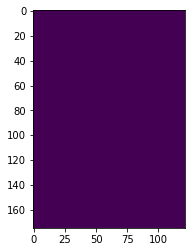

In [7]:
import matplotlib.pyplot as plt
print(output.max())
plt.imshow(output[:, :, 0], vmin=0)

**Exercise 3.4.1**

* examine the code block above, and write a function that takes as inputs the variables given in the block enclosed by `#-----------------`, the dataset information
* the code should setup the VRT files and return the list of clipped dataset filenames: `['data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.Lai_500m.vrt', 'data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.FparLai_QC.vrt']` here.
* Make sure you test your function: check that it generates the files you expect from the inputs you give.
* try to develop an automated test to see that it has worked (Homework)

**Hint**

Be clear about what you are doing in your code.

The purpose of this function is to build clipped VRT files for the conditions you set.

The conditions are the parameters driving the function.

The list of files you develop are returned. 

In [8]:
# do exercise here

An attempt at some of this is to try to split the code given cell into a few self-contained and easily testable functions. Broadly speaking, what the code does is

1. Create a list of HDF files that match a pattern (date stamp, as well as belonging to a set of tiles)
2. For each HDF file, select a layer using the GDAL selection method
3. Mosaic all the files for the given date
4. Apply a clipping mask from a vector file

Points 3 and 4 are really direct calls to GDAL functions, and can be combined into one, but we can spin off two simple functions for the first two tasks. 

Finding the files requires knowledge of the dates (day of year and year), the location of the files (a folder), as well as the tiles. Rather than use a complex wildcard/regular expression like `h1[7-8]v0[3-4]`, we can just pass a list of tiles and loop over them. We return the filenames. In the available dataset, we have a couple of years of data with four tiles, so we can test this by checking that we get four tiles for different dates.

In [9]:
def find_mcdfiles(year, doy, tiles, folder):
    """Finds MCD15 files in a given folder for a date and set of tiles
    #TODO Missing documentation
    """
    data_folder = Path(folder)
    # Find all MCD files
    mcd_files = []
    for tile in tiles:
        # Loop over all tiles, and search for files that have
        # the tile of interest
        sel_files = data_folder.glob(
            f"MCD15*.A{year:d}{doy:03d}.{tile:s}.*hdf")
        for fich in sel_files:
            mcd_files.append(fich)
    return mcd_files

# Test with two dates
results = find_mcdfiles(2017, 1, ["h17v03", "h17v04", "h18v03", "h18v04"],
                       folder="data/")
for result in results:
    print(result)
    
results = find_mcdfiles(2017, 45, ["h17v03", "h17v04", "h18v03", "h18v04"],
                       folder="data/")
for result in results:
    print(result)

data/MCD15A3H.A2017001.h17v03.006.2017014005341.hdf
data/MCD15A3H.A2017001.h17v04.006.2017014005344.hdf
data/MCD15A3H.A2017001.h18v03.006.2017014005401.hdf
data/MCD15A3H.A2017001.h18v04.006.2017014005359.hdf
data/MCD15A3H.A2017045.h17v03.006.2017053101326.hdf
data/MCD15A3H.A2017045.h17v04.006.2017053101338.hdf
data/MCD15A3H.A2017045.h18v03.006.2017053101154.hdf
data/MCD15A3H.A2017045.h18v04.006.2017053101351.hdf


The second bit of code broadly speaking just *embellishes* the previous file names by giving them a path to the internal dataset that GDAL can read. For the MCD15A3H product, this means that we build a string with the filename and the layer as 

`HDF4_EOS:EOS_GRID:"<the filename>":MOD_Grid_MCD15A3H:<the layer>`

Already, we can see that f-strings will be a very good fit for this! As a testing framework for this function, we ought to be able to open the files with `gdal.Open` and get some numbers...

Finally, we need a function that uses the previous two functions, and does the mosaicking. Here, we can consider the  options for the output. In some cases, we might just want to extract the data to a numpy array. In some other cases, we might want to store the data as a file that can be shared with others. Using a bunch of VRT files as presented above creates some issues: the original HDF files need to be present, and creating a cascade of VRT files requires that all the intermediate VRT files are present. This can quickly result in unmanageable file numbers (100s-1000s). So we can think that rather than provide a VRT (and all the dependencies, we can provide a GeoTIFF file with the mosaicked and clipped data. This is a portable format that we can pass on to others. Additionally, we can choose to return a numpy array back to the caller so it can carry on processing.

In [11]:
def mosaic_and_clip(tiles,
                    doy,
                    year,
                    folder="data/",
                    layer="Lai_500m",
                    shpfile="data/TM_WORLD_BORDERS-0.3.shp",
                    country_code="LU",
                    frmat="MEM"):
    """
    #TODO docstring missing!!!!
    """

    folder_path = Path(folder)
    # Find all files to mosaic together
    hdf_files = find_mcdfiles(year, doy, tiles, folder)

    # Create GDAL friendly-names...
    gdal_filenames = create_gdal_friendly_names(hdf_files, layer)

    if frmat == "MEM":
        g = gdal.Warp(
            "",
            gdal_filenames,
            format="MEM",
            dstNodata=255,
            cutlineDSName=shpfile,
            cutlineWhere=f"FIPS='{country_code:s}'",
            cropToCutline=True)
        data = g.ReadAsArray()
        return data
    elif frmat == "GTiff":
        geotiff_fnamex = f"{layer:s}_{year:d}_{doy:03d}_{country_code:s}.tif"
        geotiff_fname  = folder_path/geotiff_fnamex
        g = gdal.Warp(
            geotiff_fname.as_posix(),
            gdal_filenames,
            format=frmat,
            dstNodata=255,
            cutlineDSName=shpfile,
            cutlineWhere=f"FIPS='{country_code:s}'",
            cropToCutline=True)
        return geotiff_fname.as_posix()
    else:
        raise ValueError("Only MEM or GTiff formats supported!")

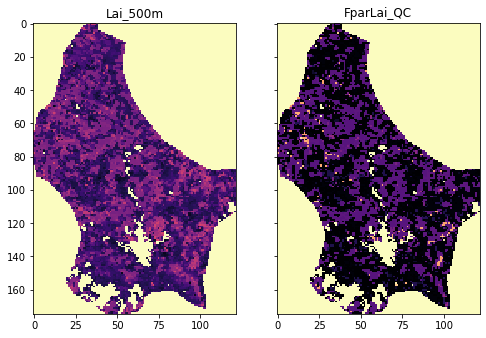

In [12]:
# Testing numpy return arrays
tiles = ["h17v03", "h17v04", "h18v03", "h18v04"]
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                       figsize=(8, 18))

for i, the_layer in enumerate(["Lai_500m", "FparLai_QC"]):
    data =  mosaic_and_clip(tiles,
                    149,
                    2017,
                    folder="data/",
                    layer=the_layer,
                    shpfile="data/TM_WORLD_BORDERS-0.3.shp",
                    country_code="LU",
                    frmat="MEM")
    axs[i].imshow(data, interpolation="nearest", vmin=0, vmax=120,
                 cmap=plt.cm.magma)
    axs[i].set_title(the_layer)

data/Lai_500m_2017_149_LU.tif
data/FparLai_QC_2017_149_LU.tif


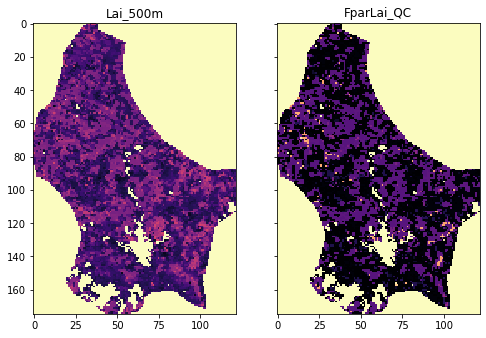

In [13]:
# Testing GeoTIFF return arrays
tiles = ["h17v03", "h17v04", "h18v03", "h18v04"]
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                       figsize=(8, 18))

for i, the_layer in enumerate(["Lai_500m", "FparLai_QC"]):
    fname =  mosaic_and_clip(tiles,
                    149,
                    2017,
                    folder="data/",
                    layer=the_layer,
                    shpfile="data/TM_WORLD_BORDERS-0.3.shp",
                    country_code="LU",
                    frmat="GTiff")
    print(fname)
    g = gdal.Open(fname)
    data = g.ReadAsArray()
    axs[i].imshow(data, interpolation="nearest", vmin=0, vmax=120,
                 cmap=plt.cm.magma)
    axs[i].set_title(the_layer)

So this appears to have worked... **visually**. A more thorough analysis would be required, possibly opening the files and checking that you can read out individual locations.

We now have an easy to call function that does a lot of complex processing behind the scenes to provide us with the **actual** data that we might want to use.

### 3.4.2.3 interpreting QA

We can now get the data describing LAI and QC for any given date (and country, given the limitations of the data in the system!)
    

The LAI dataset is decribed [on the NASA page](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mcd15a3h_v006), with the bit field information given in the [file spec](https://ladsweb.modaps.eosdis.nasa.gov/filespec/MODIS/6/MCD15A3H)

         BITFIELDS
       -------------
        0,0  MODLAND_QC bits
             '0' =  Good Quality (main algorithm with or without saturation)
             '1' =  Other Quality (back-up algorithm or fill values)

        1,1 SENSOR
             '0' = Terra
             '1' = Aqua

        2,2  DEADDETECTOR
             '0' = Detectors apparently fine for up to 50% of channels 1,2
             '1' = Dead detectors caused >50% adjacent detector retrieval

        3,4  CLOUDSTATE (this inherited from Aggregate_QC bits {0,1} cloud state)
             '00' = 0 Significant clouds NOT present (clear)
             '01' = 1 Significant clouds WERE present
             '10' = 2 Mixed cloud present on pixel
             '11' = 3 Cloud state not defined,assumed clear

        5,7  SCF_QC (3-bit, (range '000'..100') 5 level Confidence Quality score.
             '000' = 0, Main (RT) method used, best result possible (no saturation)
             '001' = 1, Main (RT) method used with saturation. Good,very usable
             '010' = 2, Main (RT) method failed due to bad geometry, empirical algorithm used
             '011' = 3, Main (RT) method failed due to problems other than geometry, 
                                  empirical algorithm used
             '100' = 4, Pixel not produced at all, value coudn't be retrieved 
                        (possible reasons: bad L1B data, unusable MOD09GA data)


In [14]:
qa_data =  mosaic_and_clip(tiles,
                    149,
                    2017,
                    layer="FparLai_QC")
print(f'Unique QA values found')
print(sorted(np.unique(qa_data)))

Unique QA values found
[0, 2, 8, 10, 16, 18, 32, 34, 40, 42, 48, 50, 97, 99, 105, 107, 113, 115, 157, 255]



We will use the bitfield `SFC_QC` as our main way to interpret quality.

The information above tells us we need to extract bits 5-7 from the QA dataset.

Let's be clear what we mean by this.

The dataset `FparLai_QC` is of data type `uint8`, unsigned 8-bit integer (i.e. unsigned byte). 

so, for example, in the file above, we see the following 19 unique codes:

In [15]:
import pandas as pd
# some pretty printing code using pandas
qas = np.array([[format(q,'3d'),format(q,'08b')] \
                for q in sorted(np.unique(qa_data))]).T
pd.DataFrame({'decimal representation': qas[0], 
              'binary representation': qas[1]})

decimal representation binary representation
0                       0              00000000
1                       2              00000010
2                       8              00001000
3                      10              00001010
4                      16              00010000
5                      18              00010010
6                      32              00100000
7                      34              00100010
8                      40              00101000
9                      42              00101010
10                     48              00110000
11                     50              00110010
12                     97              01100001
13                     99              01100011
14                    105              01101001
15                    107              01101011
16                    113              01110001
17                    115              01110011
18                    157              10011101
19                    255              11111111

Recall the truth table for the `and` operation:

| A  | B  | A and B  | 
|:---:|:---:|:---:|
|  T |  T |  T | 
|  T |  F |  F | 
|  F |  T |  F | 
|  F |  F |  F | 

For binary rerpresentation, we replace `True` by `1` and `False` by `0`. 

We also use the bitwise `and` operator `&`:

| A  | B  | A & B  | 
|:---:|:---:|:---:|
|  1 |  1 |  1 | 
|  1 |  0 |  0 | 
|  0 |  1 |  0 | 
|  0 |  0 |  0 | 

Notice that `A & B` only lets the value of `B` come through if `A` is `1`. Setting `A` as `0` effectively 'switches off' the information in `B`.

We can see this more clearly using a combination of bits:

In [16]:
A = 0b01100
B = 0b11010

print('A         =',format(A,'#07b'))
print('B         =',format(B,'#07b'))
print('C = A & B =',format(A & B,'#07b'))

A         = 0b01100
B         = 0b11010
C = A & B = 0b01000


Here, the 'mask' `A` is set to `1` for bits 2 and 3 : `0b01100`.

So only the information in bits 2 and 3 of `B` is passed through to `C`. If we change the other bits in `B`, it has no effect on `C`:



In [17]:
A = 0b01100
B = 0b01001

print('A         =',format(A,'#07b'))
print('B         =',format(B,'#07b'))
print('C = A & B =',format(A & B,'#07b'))

A         = 0b01100
B         = 0b01001
C = A & B = 0b01000


**Exercise 3.4.2**

* copy the code from the block above
* change the bit values in `B` and check that only the information in the bits set as `1` in `A` is passed through to `C`
* make a new mask `A` and re-confirm your findings for this mask

**Hint**

We are using `A` as a mask, so we set the 'pass' bits in `A` to `1` and 'block' to `0`


In [18]:
# do exercise here

So, to extract bits 5-7 (the 3 left-most bits) from an 8-bit number, we first perform a bitwise (binary) 'and' operation with the mask `0b11100000`. This has `5` `0`s to the right.

Because we have trailing zeros (to the right) of the masked value, we perform a bit shift operation (`>>`) of length 5:

In [19]:
import pandas as pd
# some pretty printing code using pandas
mask = 0b11100000

unique_qa_data = sorted(np.unique(qa_data))
decimal = np.zeros_like(unique_qa_data, dtype=object)
binary = np.zeros_like(unique_qa_data, dtype=object)
masked = np.zeros_like(unique_qa_data, dtype=object)
shifted = np.zeros_like(unique_qa_data, dtype=object)
sfc_qc = np.zeros_like(unique_qa_data, dtype=object)
for i, q in enumerate(unique_qa_data):
    decimal[i] = format(q, '3d')
    binary[i] = format(q, '08b')
    masked[i] = format ( (q & mask), '08b')
    shifted[i] = format((q & mask)>>5, '08b')
    sfc_qc[i] = format((q & mask)>>5, '03d')
    


pd.DataFrame({'decimal': decimal, 'binary': binary,
              'masked': masked,'shifted': shifted,
             'SFC_QC': sfc_qc})

decimal    binary    masked   shifted SFC_QC
0        0  00000000  00000000  00000000    000
1        2  00000010  00000000  00000000    000
2        8  00001000  00000000  00000000    000
3       10  00001010  00000000  00000000    000
4       16  00010000  00000000  00000000    000
5       18  00010010  00000000  00000000    000
6       32  00100000  00100000  00000001    001
7       34  00100010  00100000  00000001    001
8       40  00101000  00100000  00000001    001
9       42  00101010  00100000  00000001    001
10      48  00110000  00100000  00000001    001
11      50  00110010  00100000  00000001    001
12      97  01100001  01100000  00000011    003
13      99  01100011  01100000  00000011    003
14     105  01101001  01100000  00000011    003
15     107  01101011  01100000  00000011    003
16     113  01110001  01100000  00000011    003
17     115  01110011  01100000  00000011    003
18     157  10011101  10000000  00000100    004
19     255  11111111  11100000  00000111    007

Looking back at the data interpretation table:

        5,7  SCF_QC (3-bit, (range '000'..100') 5 level Confidence Quality score.
             '000' = 0, Main (RT) method used, best result possible (no saturation)
             '001' = 1, Main (RT) method used with saturation. Good,very usable
             '010' = 2, Main (RT) method failed due to bad geometry, empirical algorithm used
             '011' = 3, Main (RT) method failed due to problems other than geometry, 
                                  empirical algorithm used
             '100' = 4, Pixel not produced at all, value coudn't be retrieved 
                        (possible reasons: bad L1B data, unusable MOD09GA data)


we can see that QA values of 0,2,,8,10,16 and 18 all correspond to `Main (RT) method used, best result possible (no saturation)`, values of 32,34, 40, 42,48, 50 to `Main (RT) method used with saturation. Good,very usable` etc.

We can apply this operation to the whole QA numpy array. While can use the standard `&` and `>>` symbols, for array operations, the functions `np.bitwise_and` and `np.right_shift` are preferred:

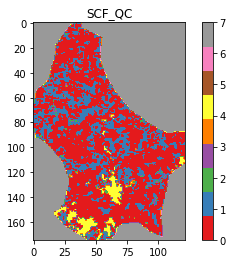

In [20]:
sfc_qa = np.right_shift(np.bitwise_and(qa_data, mask), 5)
plt.title('SCF_QC')
plt.imshow(sfc_qa,cmap=plt.cm.Set1)
plt.colorbar()

**Exercise 3.4.3**

* For the momnent, assume that we only want data which have `SCF_QC` set to `0` (i.e. `Main (RT) method used, best result possible (no saturation)`).
* read in the LAI data associated with this dataset, and set unwanted LAI data (i.e. those with `SCF_QC` not set to `0`) to Not a Number (`np.nan`)
* plot the resultant dataset

**Hint**

Use the previous function to obtain the corresponding LAI dataset for the current date.

The LAI image plotted should show 'white' (no value) everywhere the `SCF_QC` image above is not red.

In [21]:
# do exercise here

### 3.4.2.4 Deriving a weight from QA

What we want to develop here is a translation from the QA information (given in `FparLai_QC`) to a *weight* that we can apply to the data. 

If the quality is poor, we want a low weight. If the quality is good, a high weight. It makes sense to call the highest weight 1.0.

For LAI, we can use the QA information contained in bits 5-7 of `FparLai_QC` to achieve this. 

The valid codes for `SCF_QC` here are:

    0 : Main (RT) method used best result possible (no saturation)
    1 : Main (RT) method used with saturation. Good very usable
    2 : Main (RT) method failed due to bad geometry empirical algorithm used
    3 : Main (RT) method failed due to problems other than geometry empirical algorithm used
    
    
where we have translated the binary representations above to decimal.

A useful way of this to some weight is to define a real number $n$, where $0 <= n < 1$ and raise this to the power of `SCF_QC`.

So, for example is we set `n = 0.61803398875` (the [inverse golden ratio](https://en.wikipedia.org/wiki/Golden_ratio)):

SCF_QC: 0 => weight 1.0000
SCF_QC: 1 => weight 0.6180
SCF_QC: 2 => weight 0.3820
SCF_QC: 3 => weight 0.2361


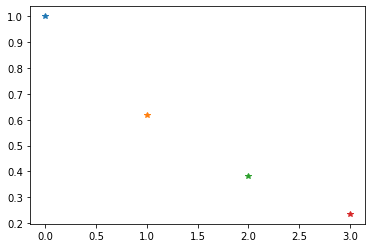

In [22]:
n = 0.61803398875

for SCF_QC in [0,1,2,3]:
    weight = n**SCF_QC
    print(f'SCF_QC: {SCF_QC} => weight {weight:.4f}')
    plt.plot(SCF_QC, weight, '*')

Then we have the following meaning for the weights:


    1.0000 : Main (RT) method used best result possible (no saturation)
    0.6180 : Main (RT) method used with saturation. Good very usable
    0.3820 : Main (RT) method failed due to bad geometry empirical algorithm used
    0.2361 : Main (RT) method failed due to problems other than geometry empirical algorithm used
    
  
Altghough we could vary the value of $n$ used and get subtle variations, this sort of weighting should produce the desired result.


**Exercise 3.4.4**

* write a function that converts from `SCF_QC` value to weight. 
* apply this to the `SCF_QC` dataset we generated above.
* display the weight image, along side the `SCF_QC` and visually check you have the weighting correct

**Hint**

Since only `[0,1,2,3]` are valid inputs, you could use conditions such as:

    (SCF_QC == i) * (n ** i)

for valid values of `i`. This should then work correctly for arrays.

In [23]:
# do exercise here

The code you write can again be split into two very simple functions that you ought to test: One is just masking and shfting the QA data to obtain the SFC_QC flag on its own. A second part deals with calculating the weights depending on whether the SFC_QC flag has values of 0, 1, 2 or 3. For any other values, it ought to be 0.

Text(0.5, 1.0, 'Weight')

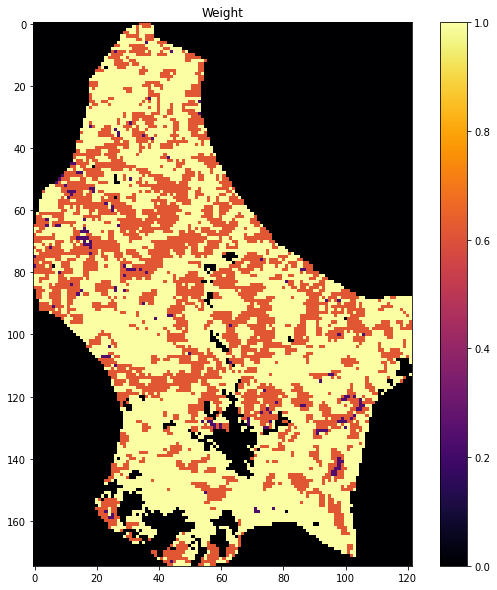

In [24]:
def get_sfc_qc(qa_data, mask57 = 0b11100000):
    sfc_qa = np.right_shift(np.bitwise_and(qa_data, mask57), 5)
    return sfc_qa

def get_scaling(sfc_qa, golden_ratio=0.61803398875):
    weight = np.zeros_like(sfc_qa, dtype=np.float)
    for qa_val in [0, 1, 2, 3]:
        weight[sfc_qa == qa_val] = np.power(golden_ratio, float(qa_val))
    return weight


sfc_qa = get_sfc_qc(qa_data)
weights = get_scaling(sfc_qa)

plt.figure(figsize=(10,10))
plt.imshow(weights, vmin=0, vmax=1, interpolation="nearest", 
           cmap=plt.cm.inferno)
plt.colorbar()
plt.title("Weight")


## 3.4.3 A time series

You should now know how to access and download datasets from the NASA servers and have developed functions to do this.

You should also know how to select a dataset from a set of hdf files, and mosaic, mask and crop the data to correspond to some vector boundary. This is a very common task in geospatial processing.

You should also know how to evaluate QA information and use this to determine some quality weight. This includes an understanding of how to interpret and use binary data fields in a QA dataset.

We now consider the case where we want to analyse a time series of data. We will use LAI over time to exemplify this.

We have already developed a file that returns an array (or a GeoTIFF) for a given date above, called `mosaic_and_clip`. We can loop over different dates while feeding the data into a so-called [*data cube*](https://news.itu.int/water-and-the-data-cube-revolution-analysis-ready-satellite-data-for-better-decisions/). This is how you get the LAI

['h17v03', 'h17v04', 'h18v03', 'h18v04']


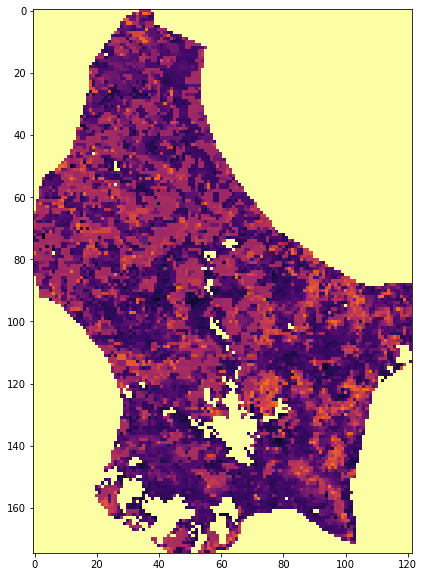

In [25]:
tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")
print(tiles)
year = 2017
doy = 149
data = mosaic_and_clip(tiles,
                    doy,
                    year,
                    folder="data/",
                    layer="Lai_500m",
                    shpfile="data/TM_WORLD_BORDERS-0.3.shp",
                    country_code="LU",
                    frmat="MEM")
plt.figure(figsize=(10,10))
plt.imshow(data/10., vmin=0, vmax=10, interpolation="nearest",
          cmap=plt.cm.inferno)

**Exercise 3.4.5**

* Test that the code above works for reading the QA dataset as well.
* Write a function that reads both the LAI dataset and the QA data, scales the LAI data appropriately and produces a weight from the QA data.
* Return the LAI data and the weight

**Hint** 

Scale LAI by multiplying by 0.1 as above.

In [26]:
# do exercise here

You should end up with something like:

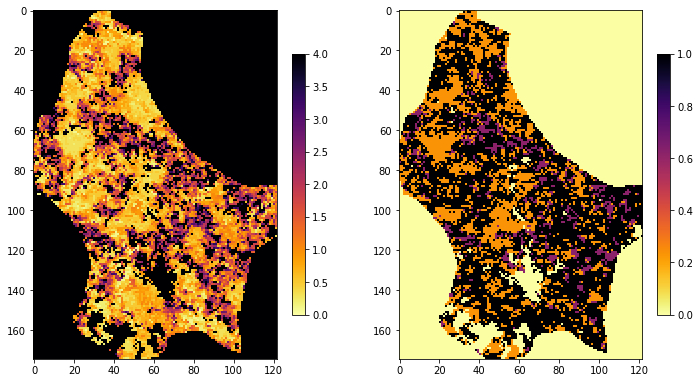

In [27]:
def process_single_date(tiles,
                    doy,
                    year,
                    folder="data/",
                    shpfile="data/TM_WORLD_BORDERS-0.3.shp",
                    country_code="LU",
                    frmat="MEM"):
    
    lai_data = mosaic_and_clip(tiles,
                    doy,
                    year,
                    folder=folder,
                    layer="Lai_500m",
                    shpfile=shpfile,
                    country_code=country_code,
                    frmat="MEM")*0.1
    # Note the scaling!
    
    qa_data = mosaic_and_clip(tiles,
                    doy,
                    year,
                    folder=folder,
                    layer="FparLai_QC",
                    shpfile=shpfile,
                    country_code=country_code,
                    frmat="MEM")
    sfc_qa = get_sfc_qc(qa_data)
    
    weights = get_scaling(sfc_qa)
    return lai_data, weights

tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")

year = 2017
doy = 273
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 24))

lai, weights =  process_single_date(tiles,
                    doy,
                    year)

img1 = axs[0].imshow(lai, interpolation="nearest", vmin=0, vmax=4,
              cmap=plt.cm.inferno_r)
img2 = axs[1].imshow(weights, interpolation="nearest", vmin=0, 
              cmap=plt.cm.inferno_r)

plt.colorbar(img1,ax=axs[0],shrink=0.2)
plt.colorbar(img2,ax=axs[1],shrink=0.2)


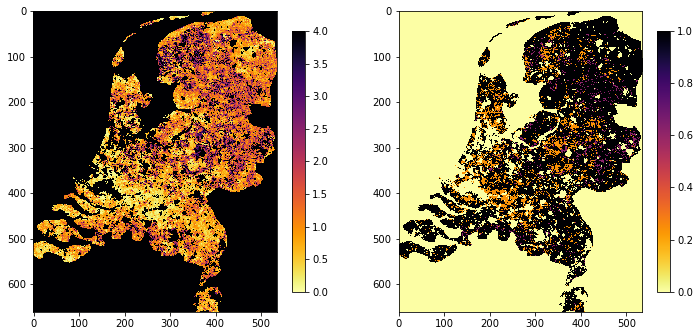

In [28]:
tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")

year = 2017
doy = 273
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 24))

lai, weights =  process_single_date(tiles,
                    doy,
                    year, country_code="NL")

img1 = axs[0].imshow(lai, interpolation="nearest", vmin=0, vmax=4,
              cmap=plt.cm.inferno_r)
img2 = axs[1].imshow(weights, interpolation="nearest", vmin=0, 
              cmap=plt.cm.inferno_r)

plt.colorbar(img1,ax=axs[0],shrink=0.2)
plt.colorbar(img2,ax=axs[1],shrink=0.2)

Try it out:

**Exercise 3.4.6**

* Now we have some code to get the LAI and weight for one day, write a function that generates an annual dataset of LAI and weight
* show the dataset shapes
* Show the code works by plotting datasets for the beggining, middle and end of year

**Hint**

The result should be a set of two 3D numpy arrays

Really, all you need do is loop over each day, and add the new dataszet to a list. 

Remember to create an initial empty list before you loop over day.

Think what might happen if the data for some day is missing.

In [29]:
# do exercise here

Although there are other ways of doing this, we can build up on what we had before, and just loop over days

In [30]:
from datetime import datetime, timedelta


def process_timeseries(year,
                       tiles,
                       folder,
                       shpfile,
                       country_code,
                       verbose=True):

    today = datetime(year, 1, 1)
    dates = []
    for i in range(92):
        if (i%10 == 0) and verbose:
            print(f"Doing {str(today):s}")
        if today.year != year:
            break
        doy = int(today.strftime("%j"))

        this_lai, this_weight = process_single_date(
            tiles,
            doy,
            year,
            folder=folder,
            shpfile=shpfile,
            country_code=country_code,
            frmat="MEM")
        if doy == 1:
            # First day, create outputs!
            ny, nx = this_lai.shape
            lai_array = np.zeros((ny, nx, 92))
            weights_array = np.zeros((ny, nx, 92))
        lai_array[:, :, i] = this_lai
        weights_array[:, :, i] = this_weight
        dates.append(today)
        today = today + timedelta(days=4)
    return dates, lai_array, weights_array


tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")

year = 2017

dates, lai_array, weights_array = process_timeseries(
    year,
    tiles,
    folder="data/",
    shpfile="data/TM_WORLD_BORDERS-0.3.shp",
    country_code="NL")

Doing 2017-01-01 00:00:00
Doing 2017-02-10 00:00:00
Doing 2017-03-22 00:00:00
Doing 2017-05-01 00:00:00
Doing 2017-06-10 00:00:00
Doing 2017-07-20 00:00:00
Doing 2017-08-29 00:00:00
Doing 2017-10-08 00:00:00
Doing 2017-11-17 00:00:00
Doing 2017-12-27 00:00:00


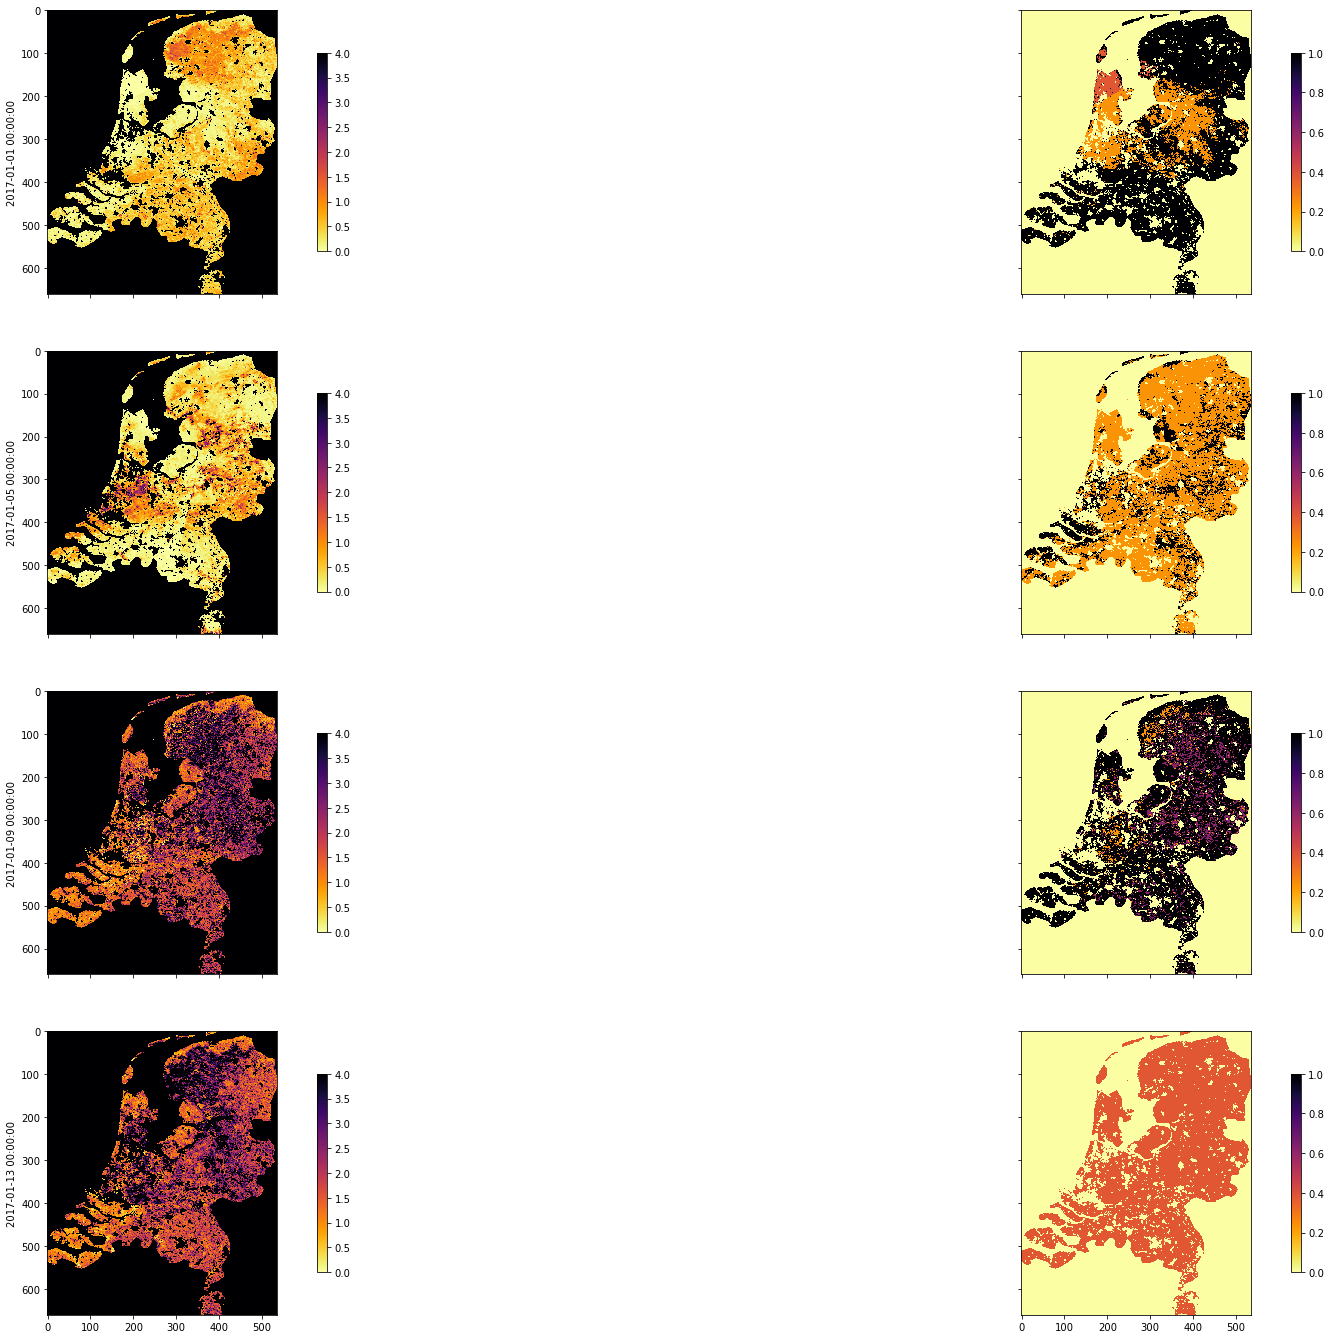

In [31]:
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True,
                        sharey=True, figsize=(32, 24))

for i, tstep in enumerate([10, 30, 60, 80]):
    img1 = axs[i][0].imshow(lai_array[:, :, tstep],
                    interpolation="nearest", vmin=0, vmax=4,
              cmap=plt.cm.inferno_r)
    img2 = axs[i][1].imshow(weights_array[:, :, tstep],
                    interpolation="nearest", vmin=0, vmax=1,
              cmap=plt.cm.inferno_r)

    plt.colorbar(img1,ax=axs[i][0],shrink=0.7)
    plt.colorbar(img2,ax=axs[i][1],shrink=0.7)
    axs[i][0].set_ylabel(dates[i])

Doing 2017-01-01 00:00:00
Doing 2017-02-10 00:00:00
Doing 2017-03-22 00:00:00
Doing 2017-05-01 00:00:00
Doing 2017-06-10 00:00:00
Doing 2017-07-20 00:00:00
Doing 2017-08-29 00:00:00
Doing 2017-10-08 00:00:00
Doing 2017-11-17 00:00:00
Doing 2017-12-27 00:00:00


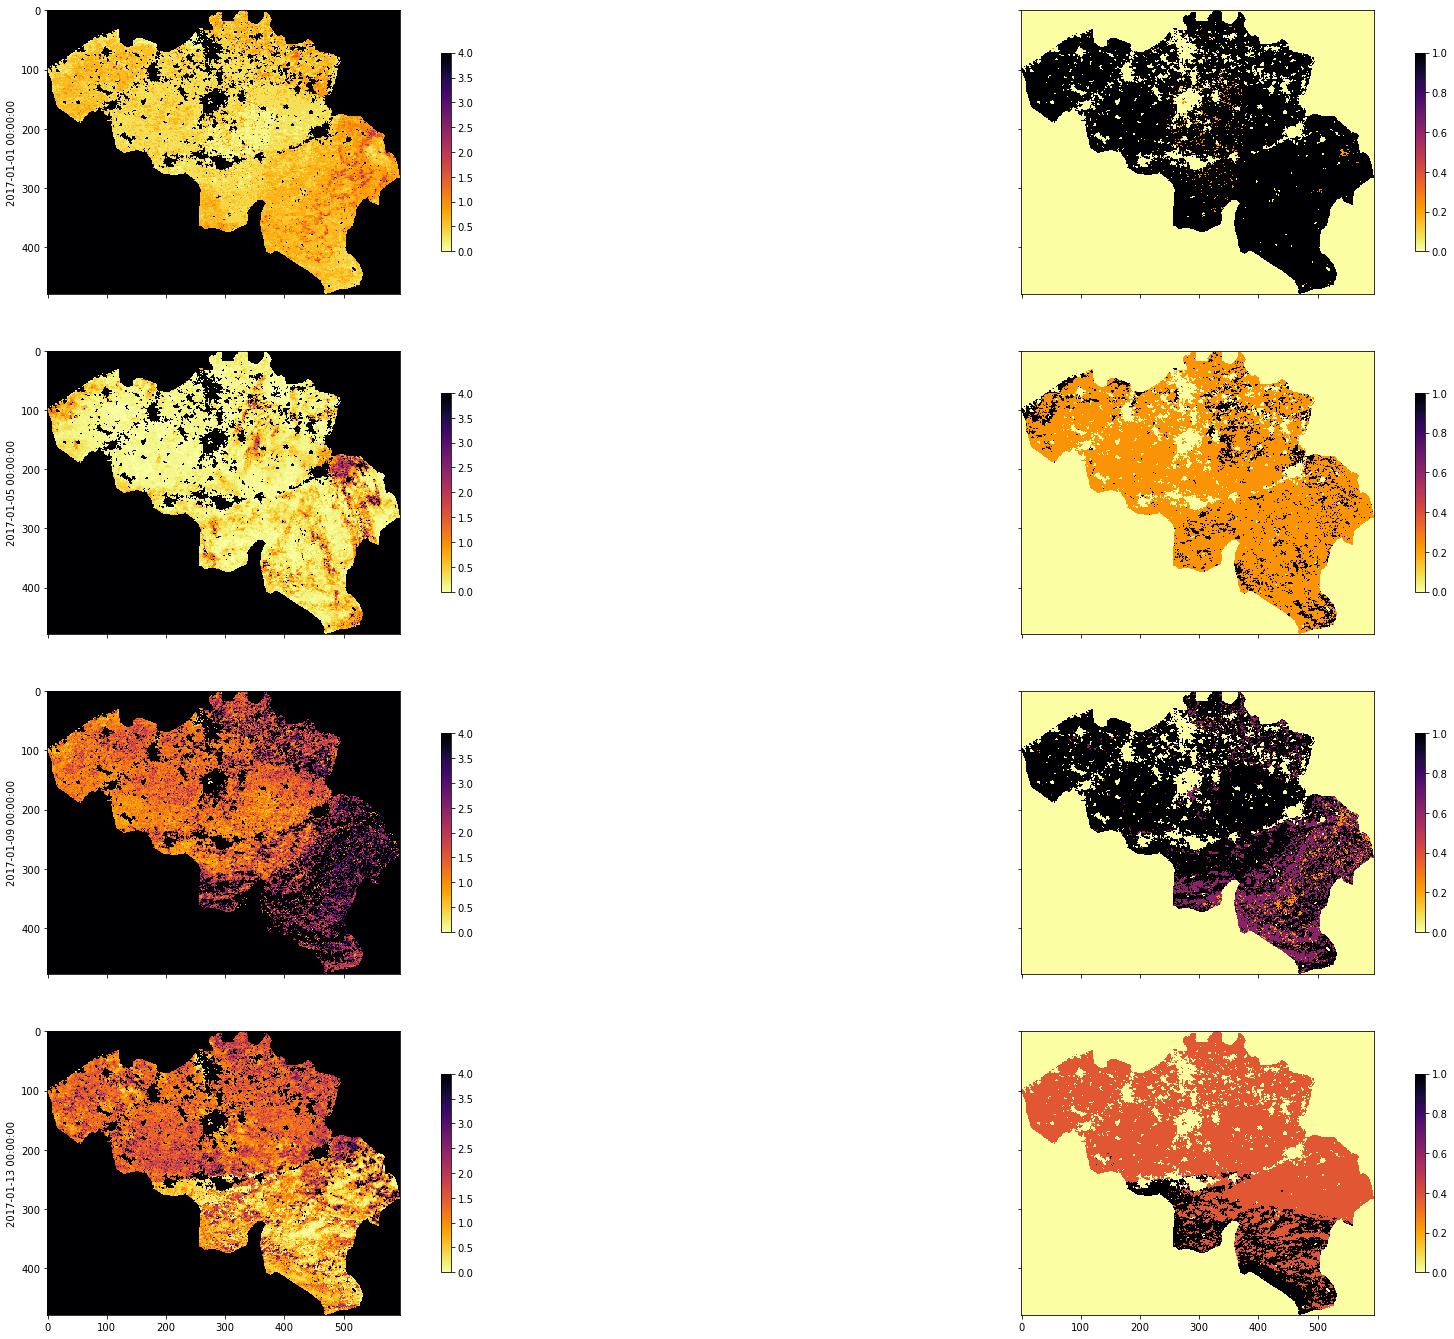

In [32]:
tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")

year = 2017

dates, lai_array, weights_array = process_timeseries(
    year,
    tiles,
    folder="data/",
    shpfile="data/TM_WORLD_BORDERS-0.3.shp",
    country_code="BE")

fig, axs = plt.subplots(
    nrows=4, ncols=2, sharex=True, sharey=True, figsize=(32, 24))

for i, tstep in enumerate([10, 30, 60, 80]):
    img1 = axs[i][0].imshow(
        lai_array[:, :, tstep],
        interpolation="nearest",
        vmin=0,
        vmax=4,
        cmap=plt.cm.inferno_r)
    img2 = axs[i][1].imshow(
        weights_array[:, :, tstep],
        interpolation="nearest",
        vmin=0,
        vmax=1,
        cmap=plt.cm.inferno_r)

    plt.colorbar(img1, ax=axs[i][0], shrink=0.7)
    plt.colorbar(img2, ax=axs[i][1], shrink=0.7)
    axs[i][0].set_ylabel(dates[i])

Now let's read the data in:

## 3.4.4 Weighted interpolation

### 3.4.4.1 Smoothing

Some animations to help understand how we can use convolution to perform a weighted interpolation. You should go through these if you have not previously come across convolution filtering.

In convolution, we combine a *signal* $y$ with a *filter* $f$ to achieve a filtered signal. For example, if we have an noisy signal, we will attempt to reduce the influence of high frequency information in the signal (a 'low pass' filter, as we let the low frequency information *pass*).

We can perform a weighted interpolation by:

* numerator   = smooth( signal $\times$ weight)
* denominator = smooth( weight)
* result = numerator/denominator

In [33]:
sigma = 8
import scipy
import scipy.ndimage.filters

x = np.arange(-3*sigma,3*sigma+1)
gaussian = np.exp((-(x/sigma)**2)/2.0)

FIPS ='LU'
dates, lai_array, weights_array = process_timeseries( year, tiles, folder="data/",
                                                     shpfile="data/TM_WORLD_BORDERS-0.3.shp", country_code=FIPS)
print(lai_array.shape, weights_array.shape) #Check the output array shapes

numerator = scipy.ndimage.filters.convolve1d(lai_array * weights_array, gaussian, axis=2,mode='wrap')
denominator = scipy.ndimage.filters.convolve1d(weights_array, gaussian, axis=2,mode='wrap')

# avoid divide by 0 problems by setting zero values
# of the denominator to not a number (NaN)
denominator[denominator==0] = np.nan

interpolated_lai = numerator/denominator
print(interpolated_lai.shape)

Doing 2017-01-01 00:00:00
Doing 2017-02-10 00:00:00
Doing 2017-03-22 00:00:00
Doing 2017-05-01 00:00:00
Doing 2017-06-10 00:00:00
Doing 2017-07-20 00:00:00
Doing 2017-08-29 00:00:00
Doing 2017-10-08 00:00:00
Doing 2017-11-17 00:00:00
Doing 2017-12-27 00:00:00
(175, 122, 92) (175, 122, 92)
(175, 122, 92)


(0.0, 6.0)

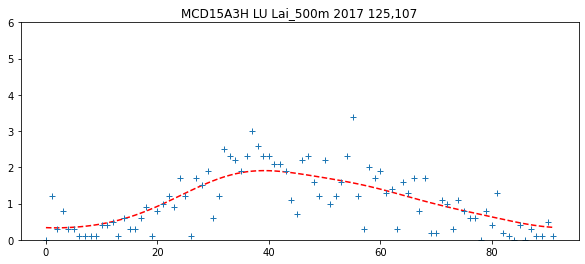

In [34]:
## find where the weight is highest, and lets look there!
sweight = weights_array.sum(axis=2)
r,c = np.where(sweight == np.max(sweight))
plt.figure(figsize=(10,4))
plt.title(f'{product} {FIPS} {params[0]} {year} {r[0]},{c[0]}')
ipixel = 0 # To plot the i-th pixel
plt.plot((interpolated_lai)[r[ipixel],c[ipixel],:],'r--')
plt.plot((lai_array)[r[ipixel],c[ipixel],:],'+')
plt.ylim(0,6)

**Exercise 3.4.7**

* select some pixels (row, col) from the lai dataset and plot the original LAI, the interpolated LAI, and the weight

In [35]:
# do exercise here

## 3.4.5 Making movies

It is often useful to animate time series information. There are several ways of doing this.

Bear in mind that the larger the datasets, number of images and/or frames, the more time it is likely to take to generate the animations. You probably don't want more than around 100 frames to make an animation of this sort.

The two approaches we will use are:

* Javascript HTML in the notebook using `anim.to_jshtml()` from `matplotlib.animation`
* Animated gif using the `imageio` library

### 3.4.5.1 Javascript HTML

This approach uses javascript in html within the notebook to genrate an animation and player. The player is useful, in that we can easily stop at and explore individual frames.

The HTML representation is written to a temporary directory (internally to [anim.to_jshtml()](https://matplotlib.org/_modules/matplotlib/animation.html#Animation.to_jshtml)) but deleted on exit.

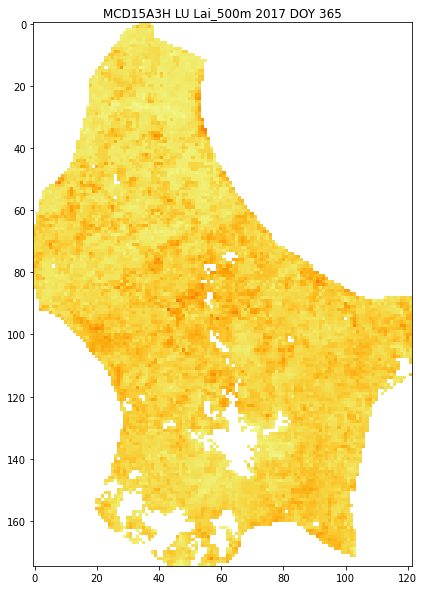

In [36]:
from matplotlib import animation
import matplotlib.pylab as plt
from IPython.display import HTML

'''
lai movie javascript/html (jshtml)
'''

#fig, ax = plt.subplots(figsize=(10,10))
fig = plt.figure(0,figsize=(10,10))

# define an animate function
# with the argument i, the frame number
def animate(i):
    # show frame i of the ilai dataset
    plt.figure(0)
    im = plt.imshow(interpolated_lai[:,:,i],vmin=0,vmax=6,cmap=plt.cm.inferno_r)
    plt.title(f'{product} {FIPS} {params[0]} {year} DOY {4*i+1:03d}')
    # make sure to return a tuple!!
    return (im,)

# set up the animation  
anim = animation.FuncAnimation(fig, animate, 
                               frames=interpolated_lai.shape[2], interval=40, 
                               blit=True)     

# display animation as HTML
HTML(anim.to_jshtml())

### 3.4.5.2 Animated gif

In the second approach, we save individual frames of an animation, and read them in, using `imageio.imread()` into a list. We choose to write the individual frames here to a temporary directory (so they are cleaned up on exit).

This list of `imageio` datasets is then fed to [`imageio.mimsave()`](https://imageio.readthedocs.io/en/stable/userapi.html) to save the sequence as an animated gif. This can then be displayed in a notebook cell (or otherwise). Note that the file XXX is saved in this case.

In [37]:
import imageio
import tempfile
from pathlib import Path

'''
lai movie as animated gif
'''

# switch interactive plotting off
# as we just want to save the frames, 
# not plot them now
plt.ioff()

allopfile = Path('images', f'{product}_{FIPS}_{params[0]}_{year}_DOY{4*i+1:03d}')
    #get_filename(FIPS,year,doy,tile,destination_folder='images')

images = []
with tempfile.TemporaryDirectory() as tmpdirname:
    ofile = f'{tmpdirname}/tmp.png'
    
    for i in range(interpolated_lai.shape[2]):
        plt.figure(0,figsize=(10,10))
        # don' display the interim frames
        plt.ioff()
        plt.clf()
        plt.imshow(interpolated_lai[:,:,i],vmin=0,vmax=6,cmap=plt.cm.inferno_r)
        plt.title(f'{product} {FIPS} {params[0]} {year} DOY {4*i+1:03d}')
        plt.colorbar(shrink=0.85)
        plt.savefig(ofile)    
        images.append(imageio.imread(ofile))
plt.clf()
imageio.mimsave(f'{allopfile}.gif', images)
print(f'{allopfile}.gif')
# switch interactive plotting back on
plt.ion()

images/MCD15A3H_LU_Lai_500m_2017_DOY013.gif


<Figure size 720x720 with 0 Axes>

**Exercise 3.4.8**

* Write a set of functions, with clear commenting and document strings tha:
    * develops the LAI and QA dataset for a given year to produce LAI data and weight
    * produces interpolated / smoothed LAI data as a numpy 3D array for the year
    * saves the resultant numpy dataset in a `npz` file
* Once y
    
**Hint**

Put all of the material above together.

Remember `np.savez()`!

In [38]:
# do exercise here